In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from tqdm import tqdm
import scipy
from scipy.optimize import minimize
from vedo import *
import meshio
import seaborn as sns
import pyvista as pv
from data_processing.mesh_to_array import *
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
import fnmatch
import cv2
import torch
from train.testing import testing
from data_processing.dataset import load_dataset, generate_points
from data_processing.obj2py import read_get, read_mat, read_egt
from utils.helper import make_cmap
cmap = make_cmap()
import copy

def get_all_cases(cfg: DictConfig, base_dir=".."):
    if cfg.data.cases == 'all':
        cases = os.listdir(os.path.join(base_dir,cfg.data.processed_data_folder))
        cases = [case.split('.')[0] for case in cases if fnmatch.fnmatch(case, 'case_TCIA*')]
        cases_number = [int(case.split('_')[-2]) for case in cases]
        # cases = [case for case, case_number in zip(cases, cases_number) if case_number < 290]
        # cases 
    else:
        cases = cfg.data.cases
    return cases




: 

# Load model and process test data

In [2]:
def load_model(path):
    cfg = load_cfg(path)
    cfg.inference_path = path
    model = hydra.utils.instantiate(cfg.learning.model, use_epair_center=cfg.data.use_epair_center)
    model.load_state_dict(torch.load(os.path.join(path,'model.pt'), map_location=cfg.learning.training.device), strict=False)
    return model, cfg

def load_seg_model(path):
    cfg = load_cfg(path)
    model = hydra.utils.instantiate(cfg.learning.segmentation_model)
    model.load_state_dict(torch.load(os.path.join(path,'seg_model.pt'), map_location=cfg.learning.training.device))
    return model, cfg

def load_cfg(path):
    with initialize(version_base=None, config_path=os.path.join(path, ".hydra"), job_name="test"):
        cfg = compose(config_name="config")
    return cfg

In [3]:
eit_path = 'outputs/2024-05-16/22-39-21'
model, cfg = load_model(eit_path)
# seg_path = 'outputs/2024-04-29/19-25-08'
# seg_model, seg_cfg = load_seg_model(seg_path)

In [8]:
cases = get_all_cases(cfg, base_dir='')    
train_dataset, val_dataset, test_dataset = load_dataset(cases,
            resolution=cfg.data.resolution, 
            electrode_resolution=cfg.data.electrode_resolution,
            mask_resolution=cfg.data.mask_resolution, 
            base_dir = '',
            raw_data_folder=cfg.data.raw_data_folder, 
            processed_data_folder=cfg.data.processed_data_folder,
            dataset_data_folder=cfg.data.dataset_data_folder,
            no_weights=cfg.data.no_weights, name_prefix=cfg.data.name_prefix,
            write_dataset=False, write_npz=False, 
            overwrite_npz=False, n_sample_points=cfg.learning.training.sample_points,
            return_electrodes=cfg.data.return_electrodes, apply_rotation=cfg.data.apply_rotation,
            apply_subsampling=cfg.data.apply_subsampling, use_epair_center=cfg.data.use_epair_center)

In [5]:
# add noise
test_dataset_noise = copy.deepcopy(test_dataset)
# test_dataset_noise.signals = test_dataset_noise.signals + np.random.normal(0, 0.5, test_dataset_noise.signals.shape)
# test_dataset_noise.signals = torch.from_numpy(np.random.normal(0, 1., test_dataset_noise.signals.shape))

# test_dataset.signals = torch.zeros_like(test_dataset.signals)

In [6]:
targets, preds = testing(model, test_dataset_noise, batch_size=cfg.learning.testing.batch_size_test, device=cfg.learning.training.device, wandb_log=False)


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:08<00:00,  3.11it/s]


Test Loss:  tensor(0.0089, device='cuda:0')
Test Lung Loss:  tensor(0.0012, device='cuda:0')


In [32]:
# seg_model.eval()
# seg_model.to(cfg.learning.training.device)
# pred_in = preds.reshape(-1, 1, 512, 512)[:10]
# pred_lung_mask = seg_model(pred_in.to(cfg.learning.training.device).float())

In [33]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# axes[0].imshow(pred_in[3].detach().cpu().numpy().squeeze(), vmin=0, vmax=0.7, cmap=cmap)
# axes[1].imshow(np.round(pred_lung_mask[3].detach().cpu().numpy().squeeze(), 0))

In [42]:
targets_case = targets.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)
preds_case = preds.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)

body_masks = [cv2.resize(mask.numpy(), (512, 512), interpolation=cv2.INTER_NEAREST) for mask in test_dataset.masks]
body_masks = np.stack(body_masks, 0).reshape(-1, 4, 4, 512, 512)
lung_masks = (test_dataset.targets <= 0.2) * (test_dataset.targets >= 0.05)
lung_masks = lung_masks.reshape(-1, 4, 4, 512, 512)
eval_lung_masks = lung_masks * (preds_case<=0.25)

In [ ]:
fontsize = 20
for i in range(preds_case.shape[0]):
    fig, axes = plt.subplots(4, 2, figsize=(10, 16))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for resistancy in range(4):
        if resistancy == 0:
            axes[resistancy,0].set_title('Ground Truth', fontsize=fontsize)
            axes[resistancy,1].set_title('Model Tomogram', fontsize=fontsize)
        axes[resistancy,0].imshow(targets_case[i,0,resistancy], vmin=0, vmax=0.7, cmap=cmap)       
        axes[resistancy,0].axis('off')
        axes[resistancy,1].imshow(preds_case[i,0,resistancy], vmin=0, vmax=0.7, cmap=cmap)
        # axes[resistancy,1].imshow(-1*body_masks[i,0,resistancy], cmap='Reds', alpha=0.2)
        axes[resistancy,1].imshow(lung_masks[i,0,resistancy], cmap='Greys', alpha=0.3)
        # axes[resistancy,1].imshow(eval_lung_masks[i,0,resistancy], cmap='Greys', alpha=0.3)
        axes[resistancy,1].axis('off')
    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Conductivity (S/m)', fontsize=fontsize)
    fig.suptitle(f'{test_dataset.cases[i]}', fontsize=fontsize)
    plt.show()
    plt.close(fig)
    if i == 10:
        break


## Inference on one case

In [4]:
case = 'case_TCIA_10_0'

In [5]:
from data_processing.dataset import combine_electrode_positions

In [71]:
data = np.load('data/processed/'+case+'.npz')
signals = torch.from_numpy(data['signals'])
electrodes = torch.from_numpy(data['electrodes'])
points = torch.from_numpy(data['points'])
targets = torch.from_numpy(data['targets'])

# normalize
signals = (signals-train_dataset.train_mean) / train_dataset.train_std
points = points[:,:,:2]
points = ((points - train_dataset.points_min) / (train_dataset.points_max - train_dataset.points_min)) * 2 - 1
electrodes[:,:,:2] = ((electrodes[:,:,:2] - train_dataset.points_min) / (train_dataset.points_max - train_dataset.points_min)) * 2 - 1
electrodes = combine_electrode_positions(electrodes)

In [72]:
_, pred = testing(model, [signals.float(), electrodes.float(), points.float()], batch_size=1, device=cfg.learning.training.device, wandb_log=False)
targets = targets.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)
targets = np.moveaxis(targets,1,2)
preds_case = pred.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)
preds_case = np.moveaxis(preds_case,1,2)

# SIRT
threshold = 50
tomogram = np.array([read_egt('data/raw/case_TCIA_10_0/tomograms_rad/level_1_15_radweight_1.egt'),
                        read_egt('data/raw/case_TCIA_10_0/tomograms_rad/level_2_15_radweight_1.egt')])
tomogram = np.where(tomogram>threshold, threshold, tomogram)
tomogram = np.where(tomogram==0, 0, 1/tomogram)


Test Loss:  nan
Test Lung Loss:  nan


/scratch/tmp/nibdombe/ipykernel_1186/2313709471.py:12: RuntimeWarning: divide by zero encountered in divide
  tomogram = np.where(tomogram==0, 0, 1/tomogram)


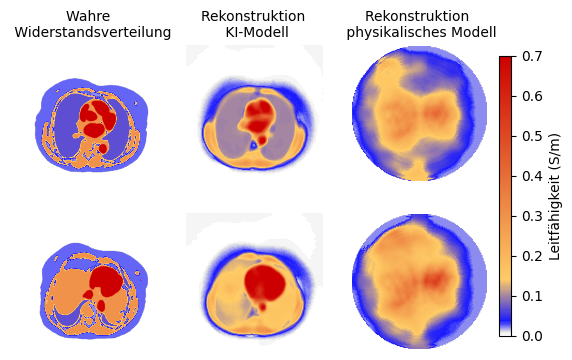

In [75]:
fontsize = 10
for i in range(preds_case.shape[0]):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for level in range(2):
        axes[level,0].imshow(targets[i,2,level], vmin=0, vmax=0.7, cmap=cmap)
        axes[level,0].axis('off')
        axes[level,1].imshow(preds_case[i,2,level], vmin=0, vmax=0.7, cmap=cmap)
        axes[level,1].axis('off')
        axes[level,2].imshow(tomogram[level], vmin=0, vmax=0.7, cmap=cmap)
        axes[level,2].axis('off')
        if level==0:
            axes[level,0].set_title('Wahre \n Widerstandsverteilung', fontsize=fontsize)
            axes[level,1].set_title('Rekonstruktion \n KI-Modell', fontsize=fontsize)
            axes[level,2].set_title('Rekonstruktion \n physikalisches Modell', fontsize=fontsize)
    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Leitfähigkeit (S/m)', fontsize=fontsize)
    # fig.suptitle(f'{test_dataset.cases[i]}', fontsize=fontsize)
    plt.show()
    plt.close(fig)
    if i == 10:
        break


IndexError: index 2 is out of bounds for axis 0 with size 2

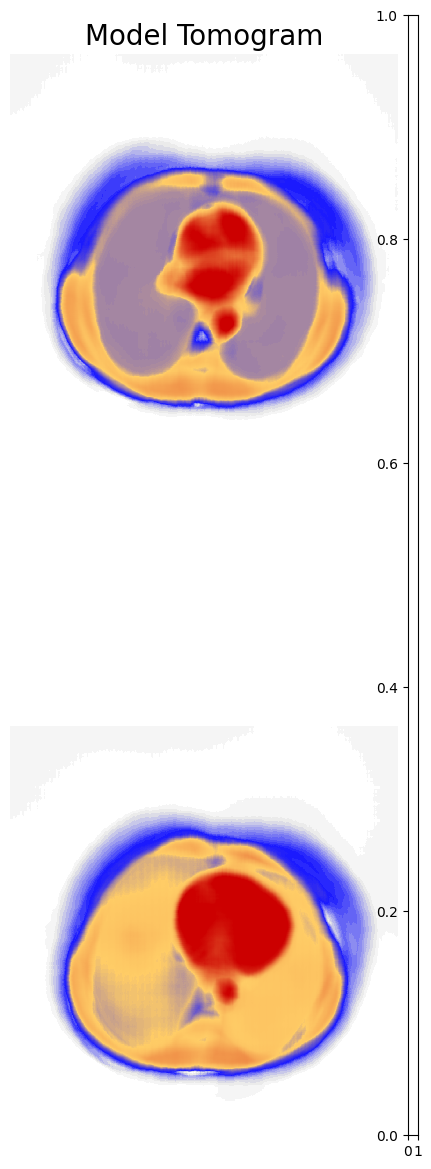

In [ ]:
preds_case = pred.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)
preds_case = np.moveaxis(preds_case,1,2)
fontsize = 20
for i in range(preds_case.shape[0]):
    fig, axes = plt.subplots(2, 1, figsize=(5, 16))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for resistancy in range(4):
        if resistancy == 0:
            axes[resistancy].set_title('Model Tomogram', fontsize=fontsize)
        axes[resistancy].imshow(preds_case[i,2,resistancy], vmin=0, vmax=0.7, cmap=cmap)
        axes[resistancy].axis('off')
    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Conductivity (S/m)', fontsize=fontsize)
    fig.suptitle(f'{test_dataset.cases[i]}', fontsize=fontsize)
    plt.show()
    plt.close(fig)
    if i == 10:
        break


# Inference on training data

In [30]:
train_dataset.targets.shape

torch.Size([3024, 512, 512, 1])

In [28]:
train_dataset.apply_subsampling = False
train_dataset.training = False
data = [train_dataset.signals[0].unsqueeze(0).float(), train_dataset.electrodes[0].unsqueeze(0).float(), train_dataset.points[0,:,:2].unsqueeze(0).float()]
_, preds = testing(model, data, batch_size=cfg.learning.testing.batch_size_test, device=cfg.learning.training.device, wandb_log=False)
targets = train_dataset.targets[0]

Test Loss:  nan
Test Lung Loss:  nan


In [31]:
targets_case = targets.detach().cpu().numpy().squeeze().reshape(-1, 1, 1, 512, 512)
preds_case = preds.detach().cpu().numpy().squeeze().reshape(-1, 1, 1, 512, 512)

body_masks = [cv2.resize(mask.numpy(), (512, 512), interpolation=cv2.INTER_NEAREST) for mask in train_dataset.masks]
body_masks = np.stack(body_masks, 0).reshape(-1, 1, 1, 512, 512)

lung_masks = (train_dataset.targets <= 0.2) * (train_dataset.targets >= 0.05)
lung_masks = lung_masks.reshape(-1, 1, 1, 512, 512)
# eval_lung_masks = lung_masks * (preds_case<=0.25)

IndexError: index 1 is out of bounds for axis 2 with size 1

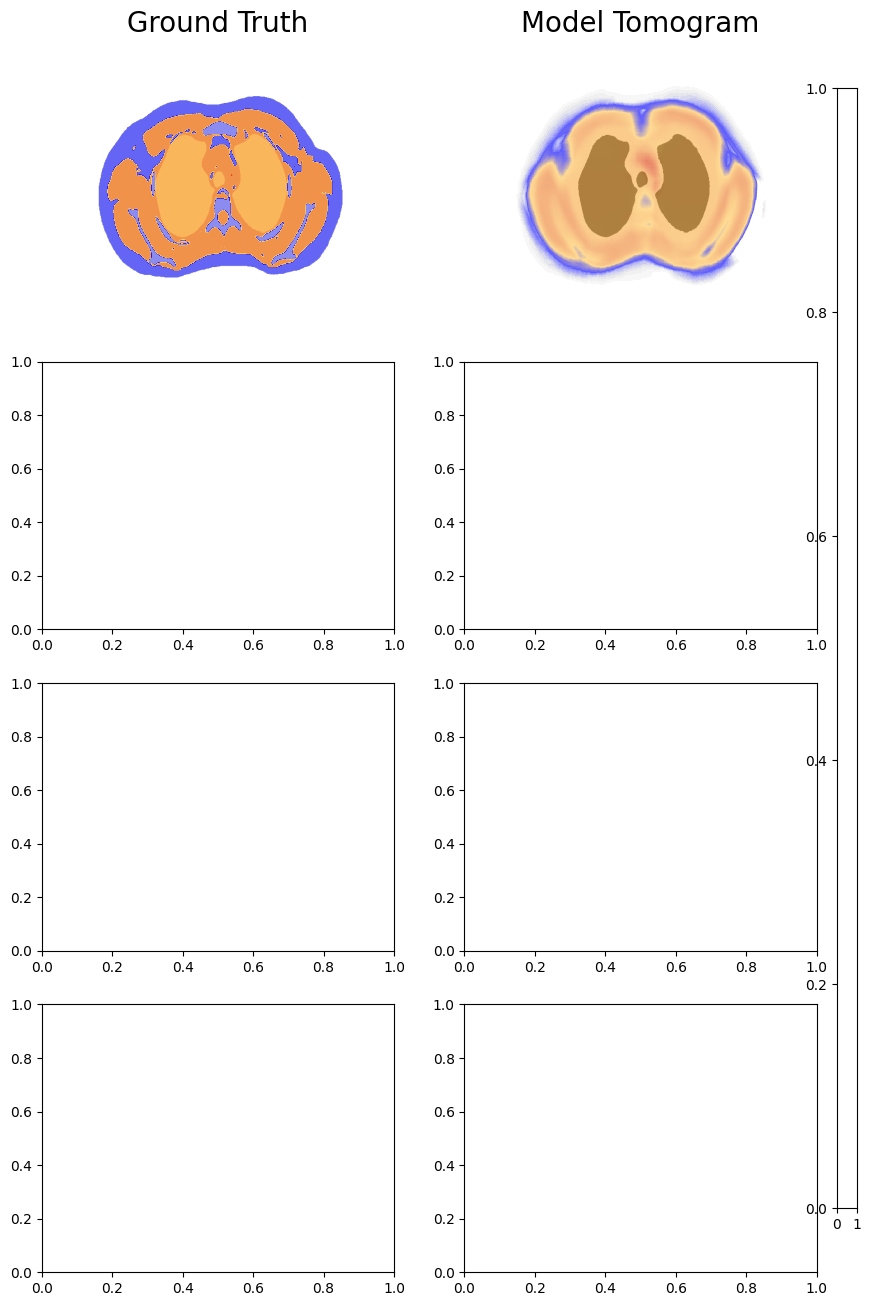

In [32]:
fontsize = 20
for i in range(preds_case.shape[0]):
    fig, axes = plt.subplots(4, 2, figsize=(10, 16))
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    for resistancy in range(4):
        if resistancy == 0:
            axes[resistancy,0].set_title('Ground Truth', fontsize=fontsize)
            axes[resistancy,1].set_title('Model Tomogram', fontsize=fontsize)
        axes[resistancy,0].imshow(targets_case[i,0,resistancy], vmin=0, vmax=0.7, cmap=cmap)       
        axes[resistancy,0].axis('off')
        axes[resistancy,1].imshow(preds_case[i,0,resistancy], vmin=0, vmax=0.7, cmap=cmap)
        # axes[resistancy,1].imshow(-1*body_masks[i,0,resistancy], cmap='Reds', alpha=0.2)
        axes[resistancy,1].imshow(lung_masks[i,0,resistancy], cmap='Greys', alpha=0.3)
        # axes[resistancy,1].imshow(eval_lung_masks[i,0,resistancy], cmap='Greys', alpha=0.3)
        axes[resistancy,1].axis('off')
    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(0, 0.7)
    cbar = fig.colorbar(sm, cax=cbar_ax)        
    cbar.set_label('Conductivity (S/m)', fontsize=fontsize)
    fig.suptitle(f'{test_dataset.cases[i]}', fontsize=fontsize)
    plt.show()
    plt.close(fig)
    if i == 10:
        break


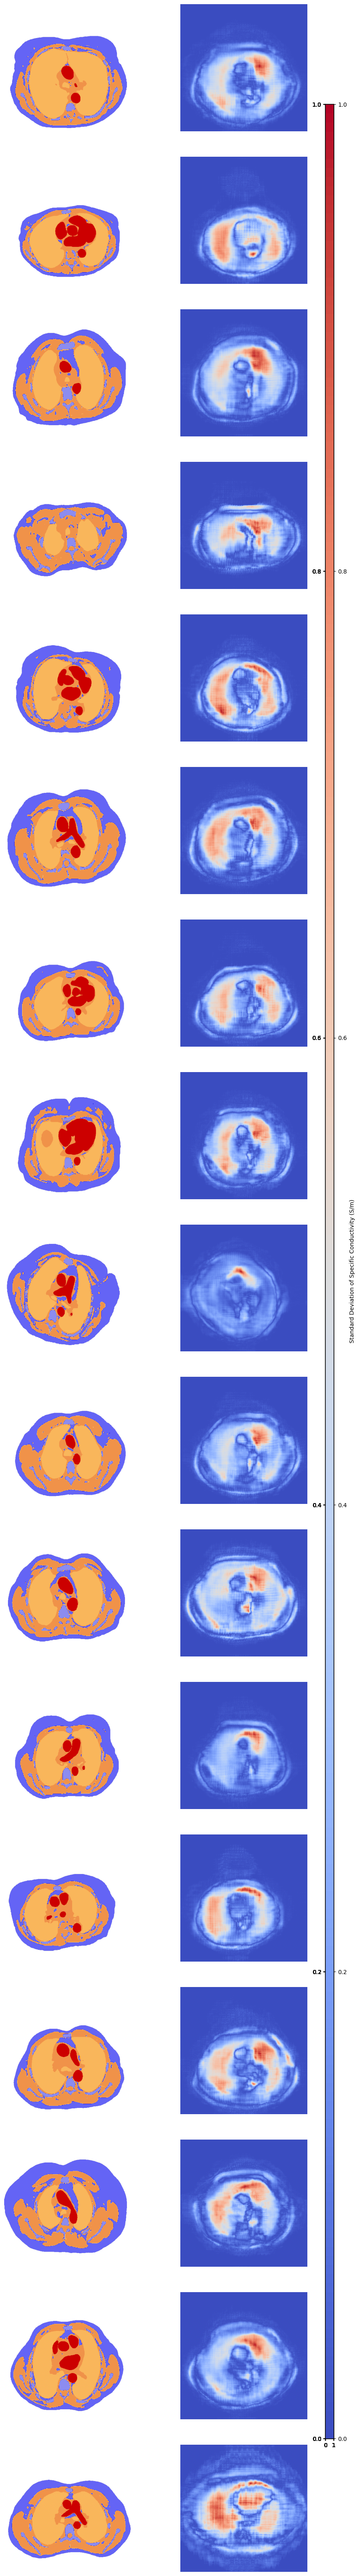

In [18]:
targets_case = targets.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512)
preds_case_std = np.clip(preds.detach().cpu().numpy().squeeze().reshape(-1, 4, 4, 512, 512), 0, 0.7)
preds_case_std = preds_case_std.std(axis=(2))
fontsize = 10
fig, axes = plt.subplots(preds_case.shape[0], 2, figsize=(10, 80))
for i in range(preds_case.shape[0]):
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    axes[i,0].imshow(targets_case[i,0,0], vmin=0, vmax=0.7, cmap=cmap)
    axes[i,0].axis('off')
    axes[i,1].imshow(preds_case_std[i,0], cmap='coolwarm')
    axes[i,1].axis('off')
# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap='coolwarm')
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Standard Deviation of Specific Conductivity (S/m)', fontsize=fontsize)
# fig.suptitle(f'{test_dataset.cases[i]}', fontsize=fontsize)
plt.show()
plt.close(fig)


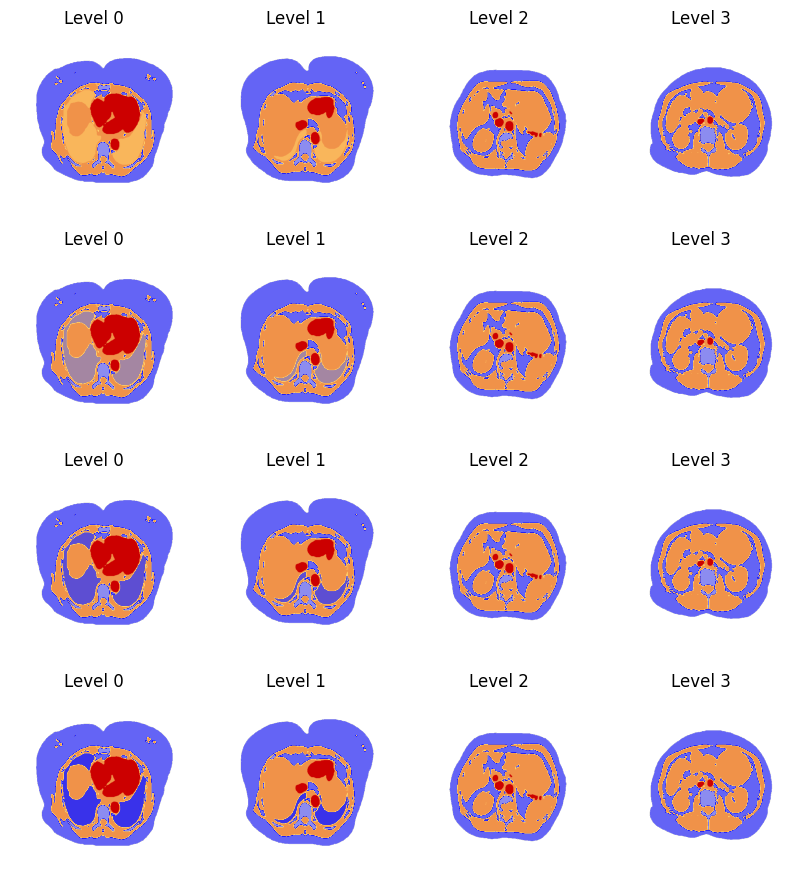

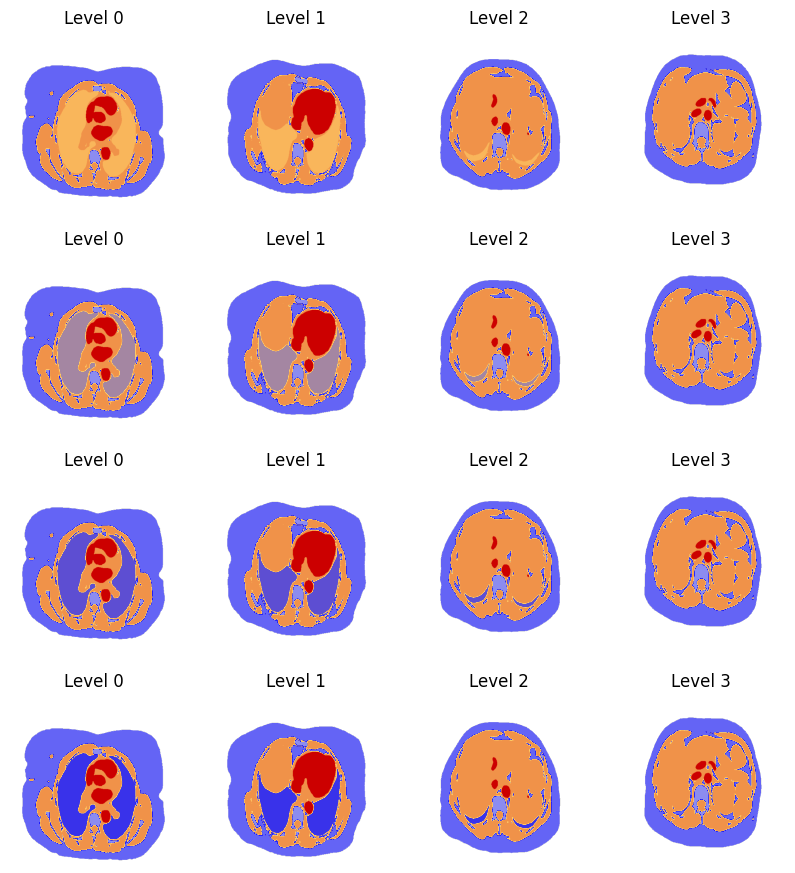

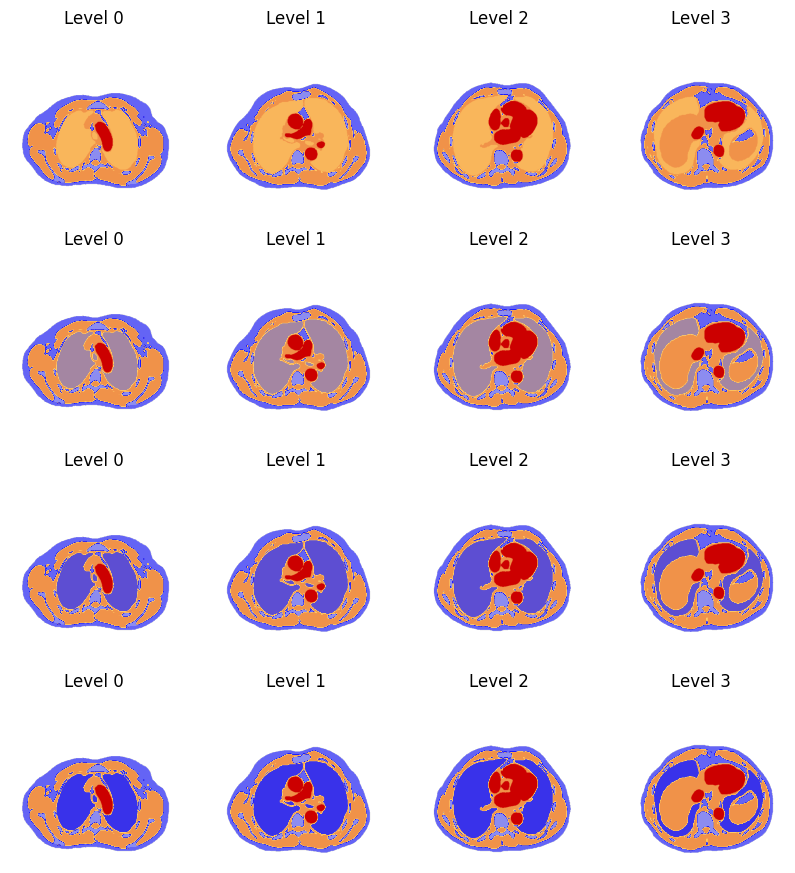

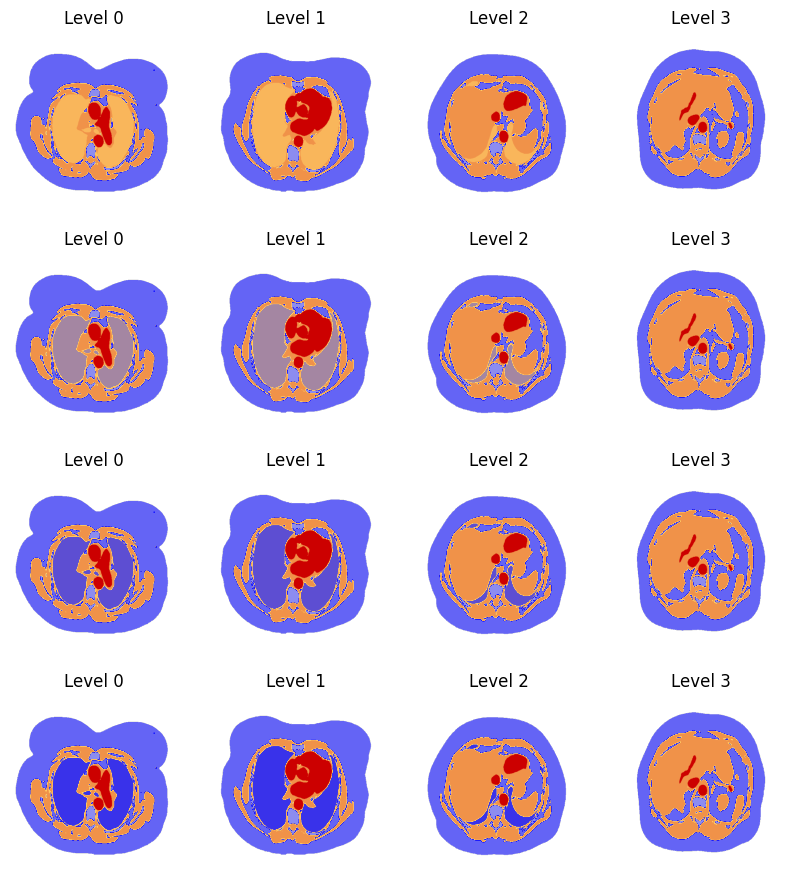

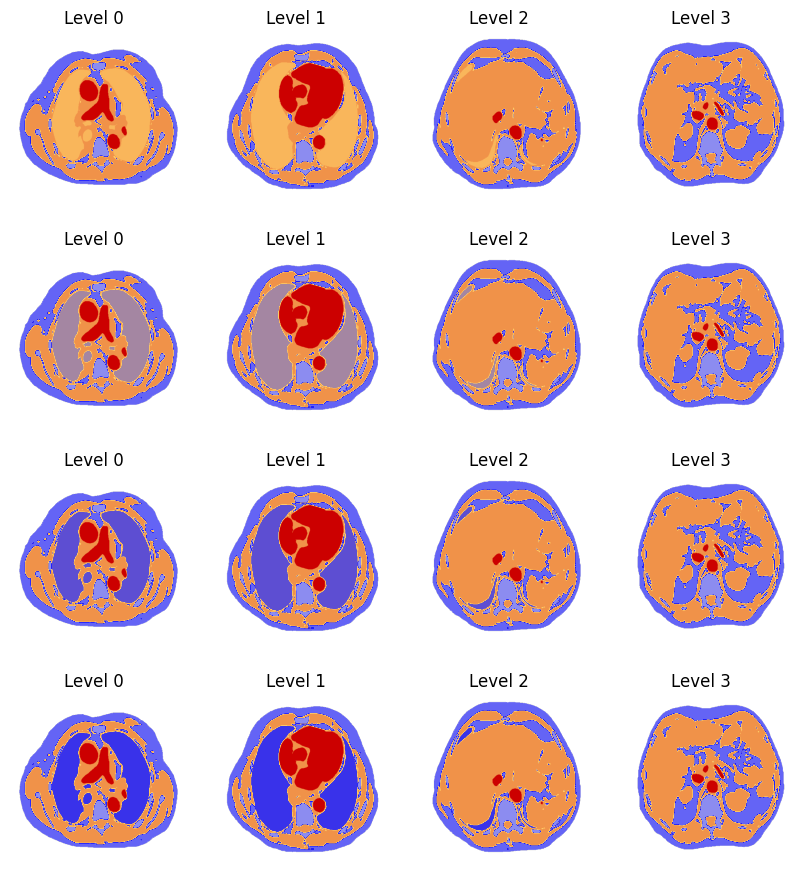

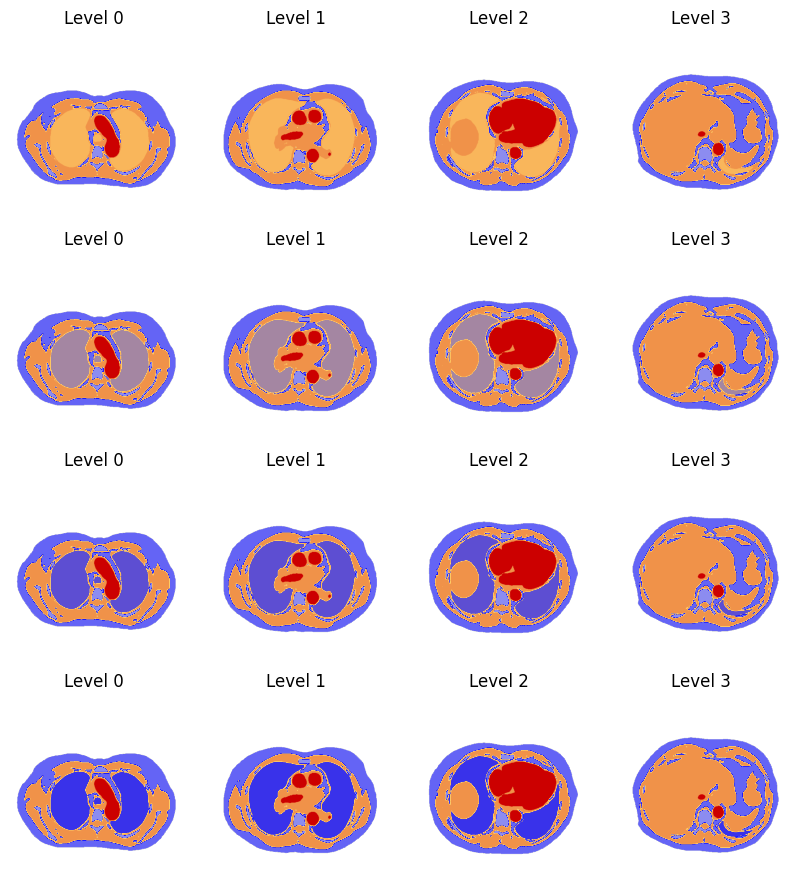

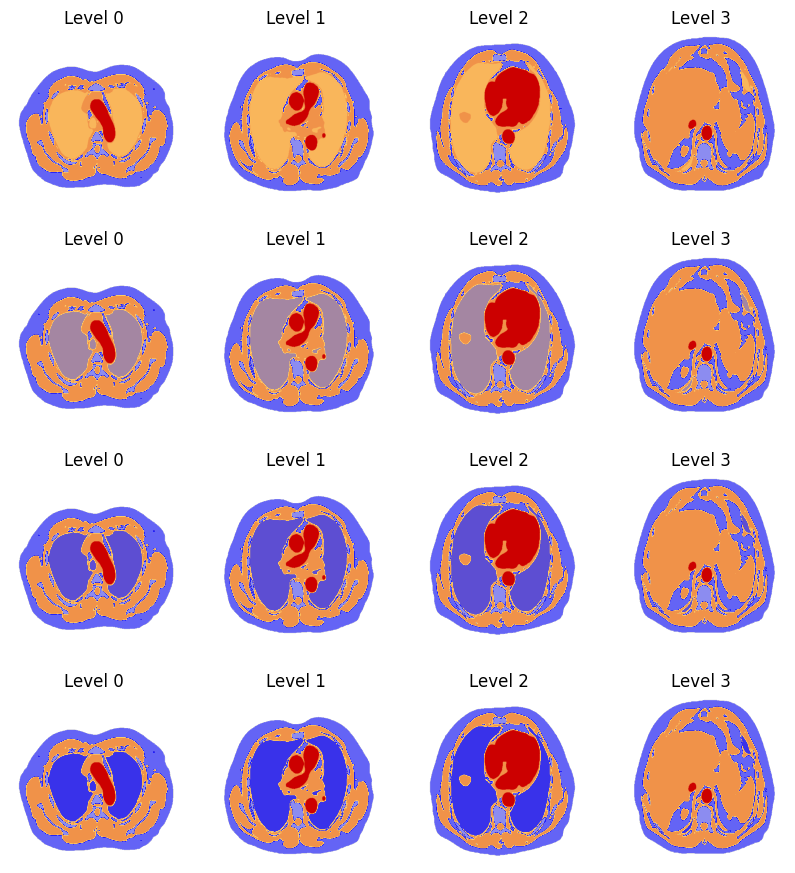

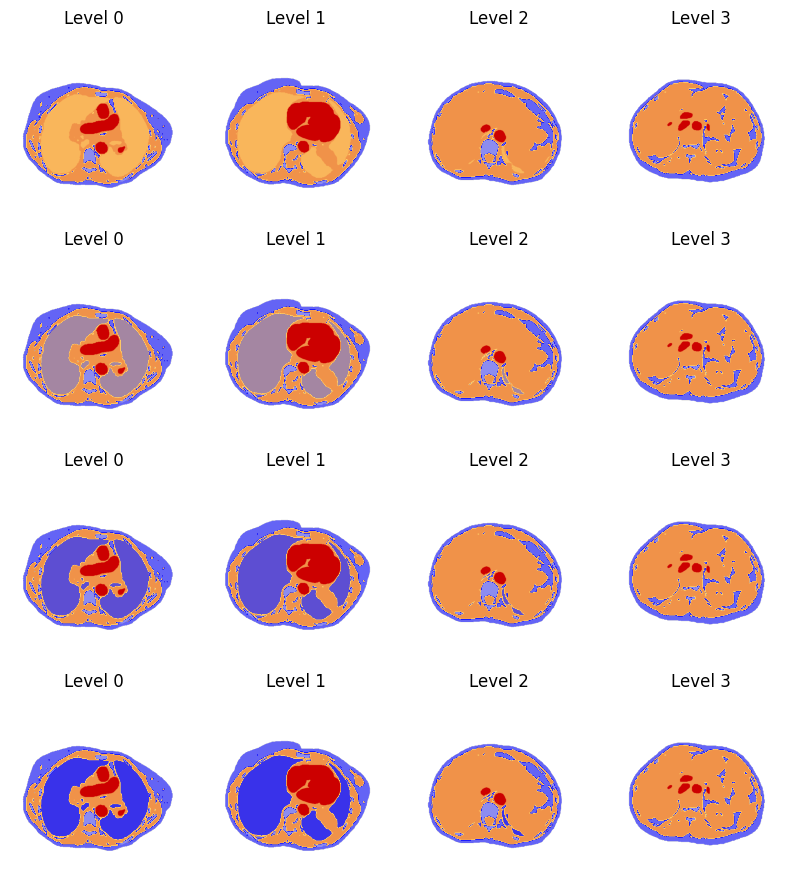

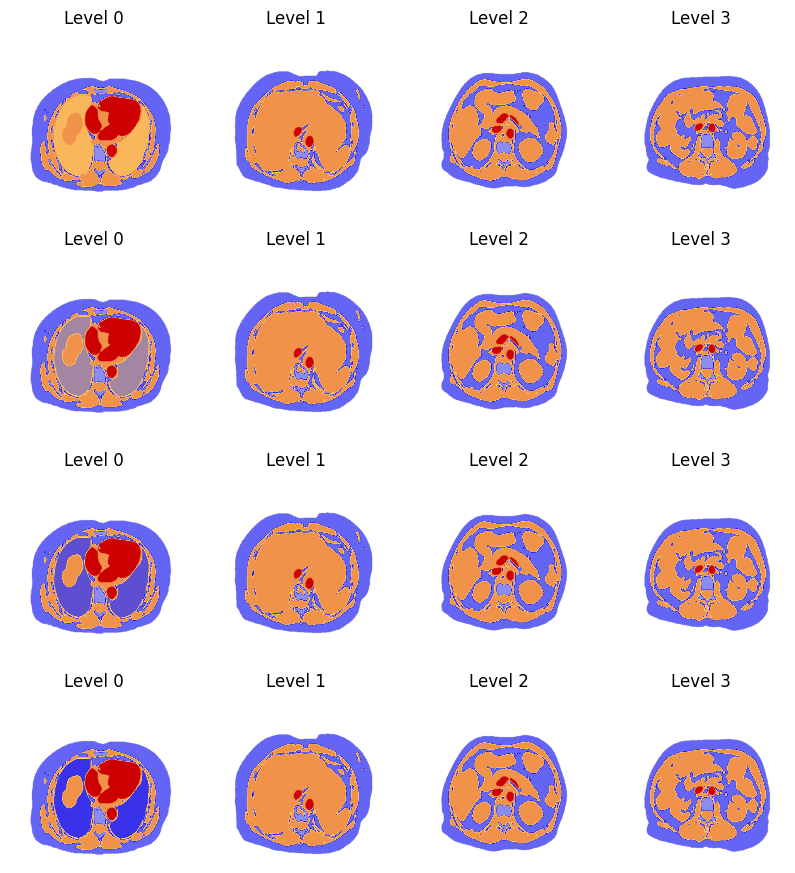

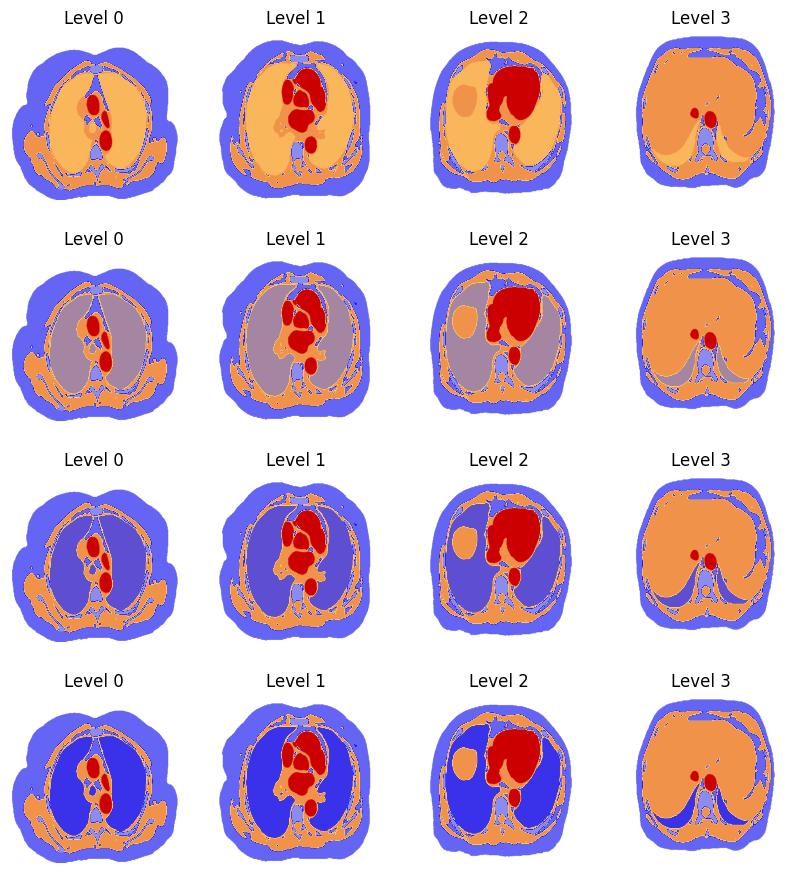

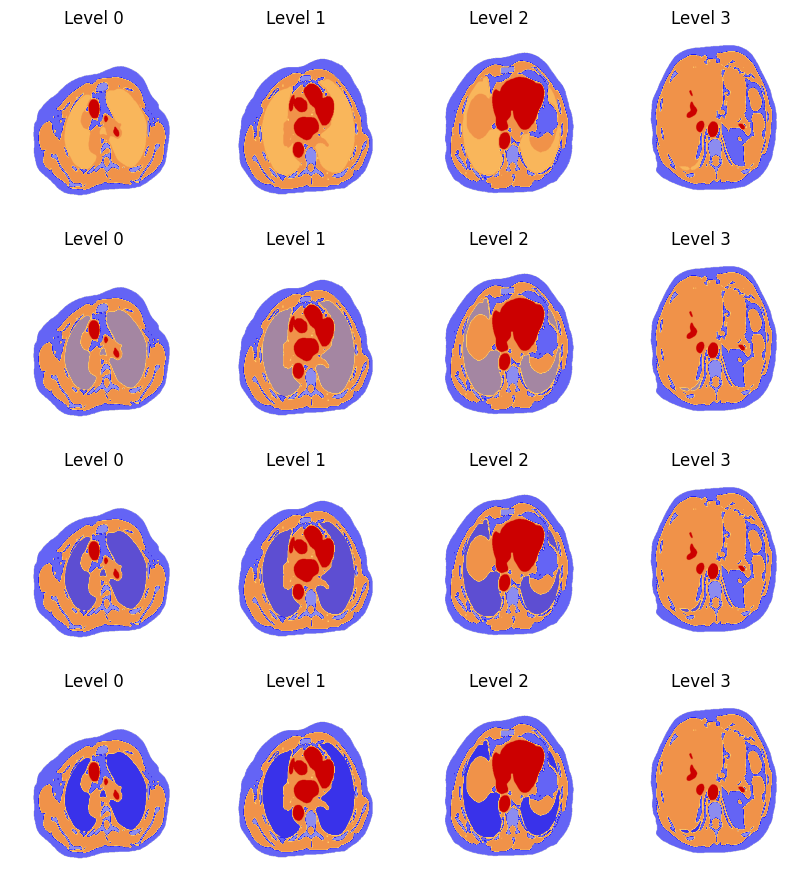

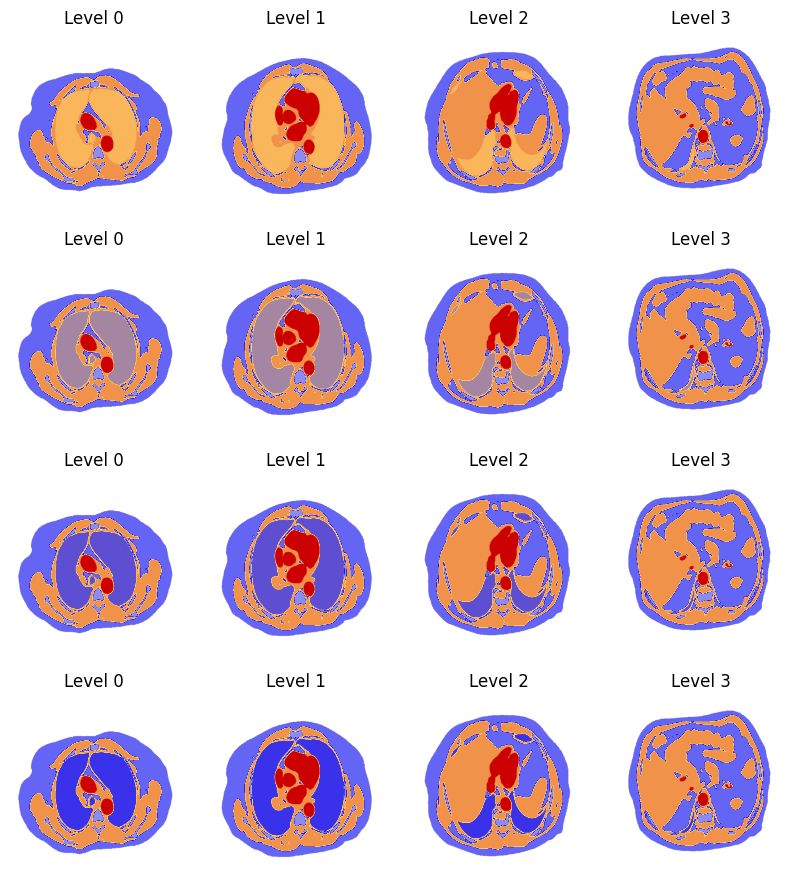

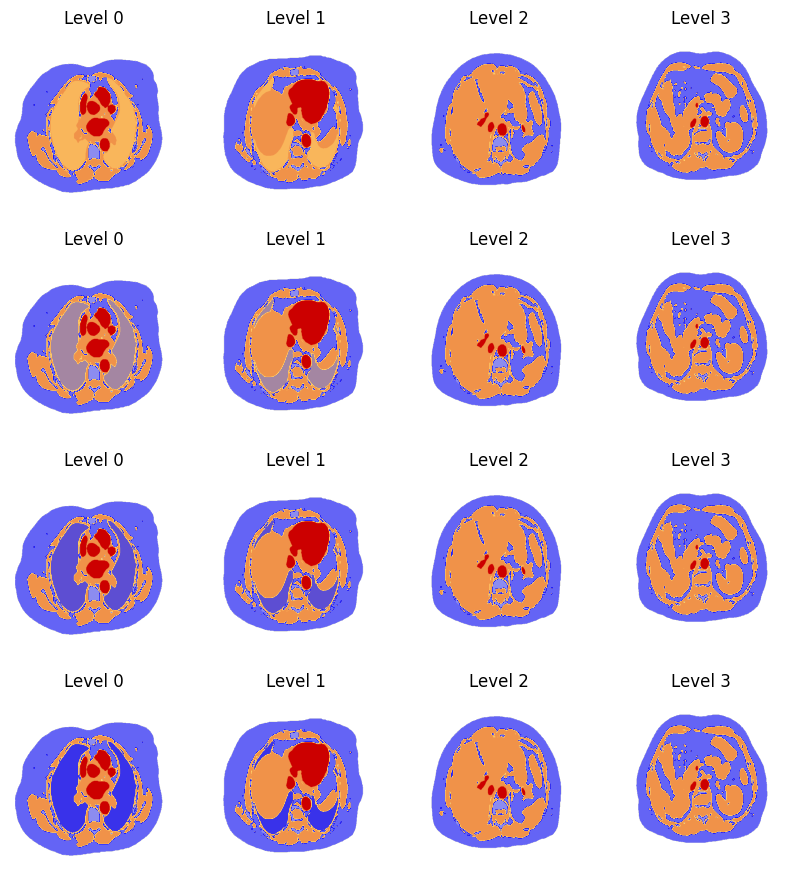

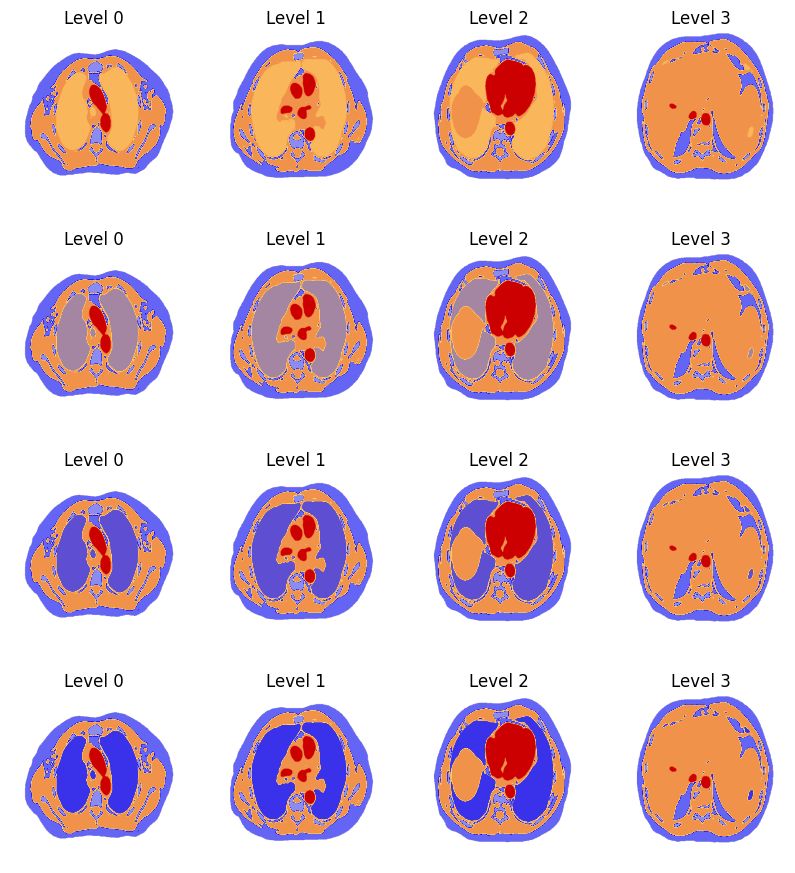

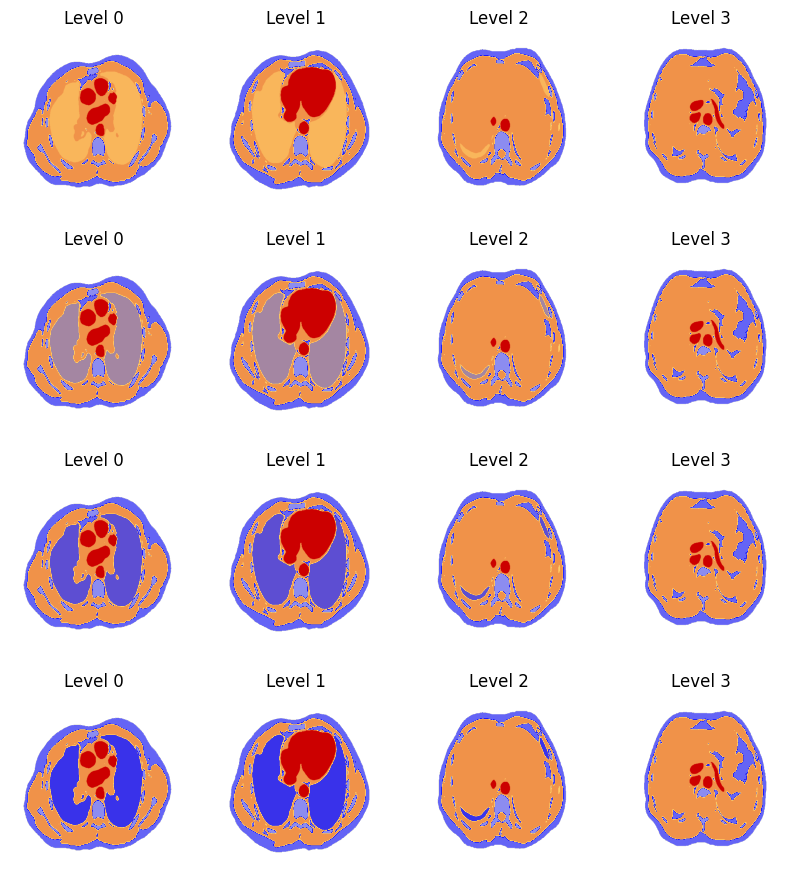

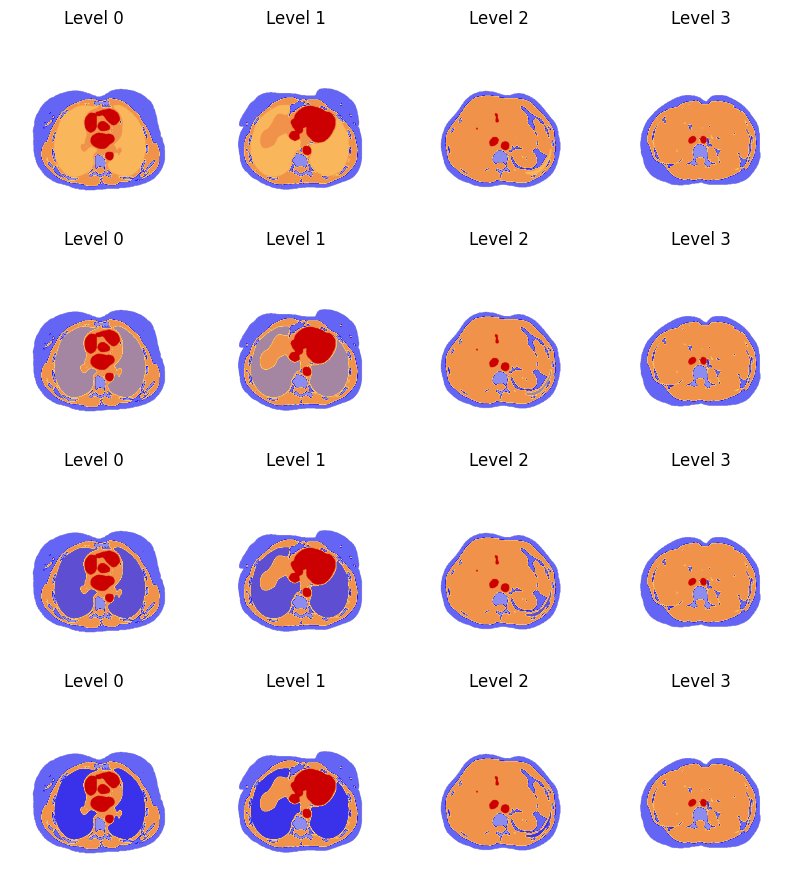

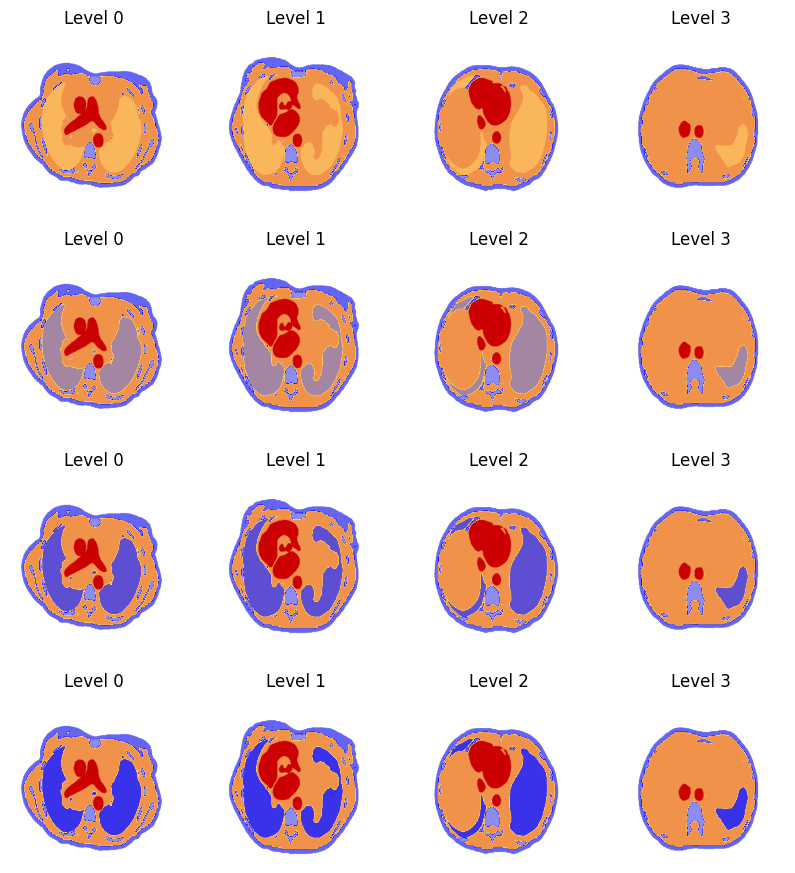

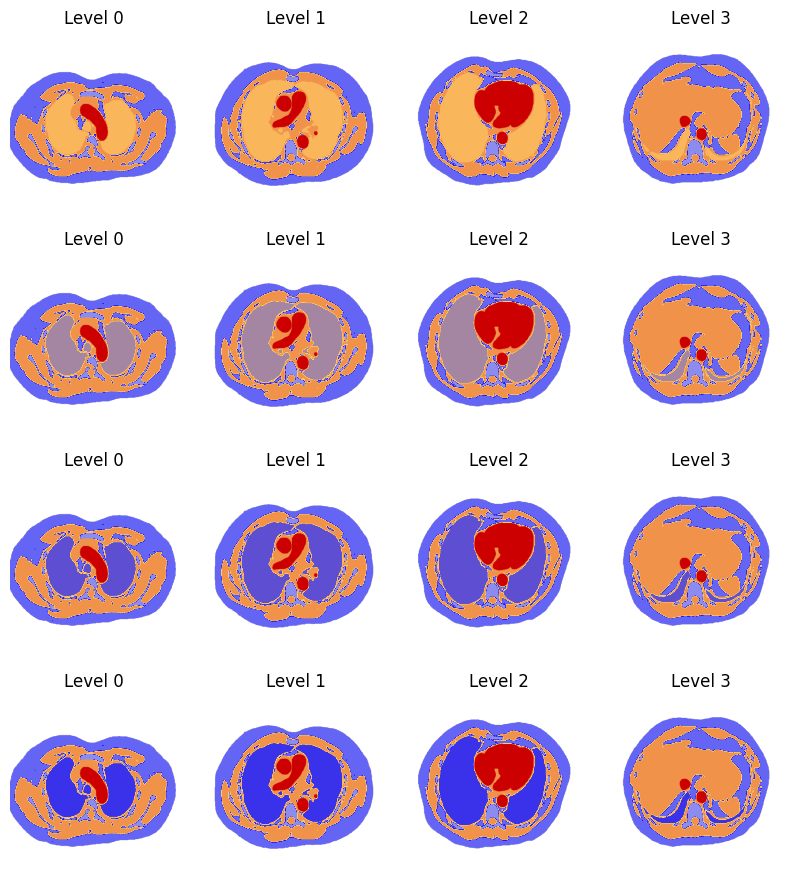

In [16]:
# images
t = test_dataset.targets.reshape(-1, 4, 4, 512, 512)
t = t.moveaxis(2, 1)
t = t.reshape(-1, 16, 512, 512)
# level
l = test_dataset.levels.reshape(-1, 4, 4).moveaxis(2,1).reshape(-1, 16)
# electrodes
e = test_dataset.electrodes.reshape(-1, 4, 4, 16, 3).moveaxis(2, 1).reshape(-1, 16, 16, 3)
e = (e[:, :, :, :2] + 1) * 256

for i in range(preds_case.shape[0]):
    fig, axes = plt.subplots(4, 4, figsize=(10, 11))
    for resistancy in range(16):
        if resistancy == 0:
            axes.flatten()[resistancy].set_ylabel('Lung 5 Ohm')
        if resistancy == 3:
            axes.flatten()[resistancy].set_ylabel('Lung 10 Ohm')
        if resistancy == 7:
            axes.flatten()[resistancy].set_ylabel('Lung 15 Ohm')
        if resistancy == 11:
            axes.flatten()[resistancy].set_ylabel('Lung 20 Ohm')

        axes.flatten()[resistancy].set_title(f'Level {str(l[i,resistancy].numpy()*-1+3)}')
        axes.flatten()[resistancy].imshow(t[i,resistancy], cmap=cmap)
        # axes.flatten()[resistancy].scatter(e[i,resistancy,:,0], e[i,resistancy,:,1], marker='x', c='r')
        axes.flatten()[resistancy].axis('off')
    # Add colorbar to the figure
    # fig.suptitle(f'{test_dataset.cases[i]}', fontsize=12)
    plt.show()
    plt.close(fig)
    if i == 20:
        break

In [38]:
train_dataset.signals.max()

tensor(117.1804)

# Use 'real' data

In [113]:
real_signals = read_get('data/raw/case_real/Tag1/Tag_01_Msg_19_SF_1_U_top_I_top_372-459_min_mean.get')[:208]*1000

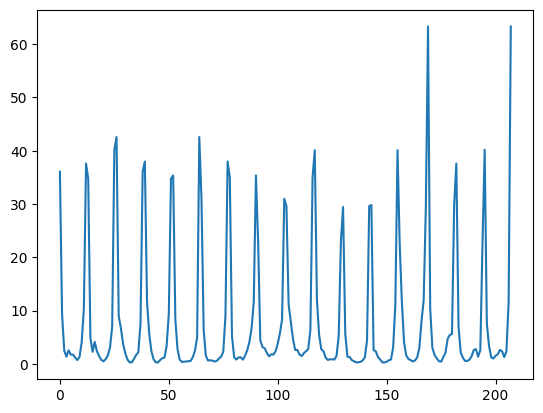

In [114]:
plt.plot(real_signals)

## get electrode position from ME0*

In [115]:
electrodes = read_mat('/home/nibdombe/deep_eit/data/raw/case_0/electrodes/electrodes.mat').reshape(-1, 16, 3)

In [116]:
real_electrodes = electrodes[0]

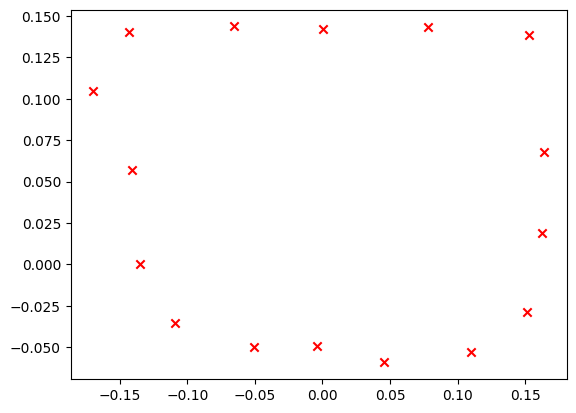

In [117]:
plt.scatter(real_electrodes[:,0], real_electrodes[:,1], marker='x', c='r')

## normalize

In [118]:
mean_signals = test_dataset.train_mean
std_signals = test_dataset.train_std
real_signals = (torch.from_numpy(real_signals) - mean_signals) / std_signals

min_xy = test_dataset.points_min
max_xy = test_dataset.points_max
real_electrodes = (real_electrodes - min_xy) / (max_xy - min_xy) * 2 - 1
real_electrodes = torch.from_numpy(real_electrodes.reshape(-1, 16, 3))
real_electrodes[:,:,2] = 1 

real_signals = real_signals.reshape(1, 16, 13).float()
real_electrodes = real_electrodes.reshape(1, 16, 3).float()
points = generate_points(resolution=512)
points = points.reshape(1, -1, 2).float()

In [119]:
pred = testing(model, data=[real_signals, real_electrodes, points], batch_size=1, device='cuda:0', wandb_log=False)[1].reshape(512, 512)

Test Loss:  nan


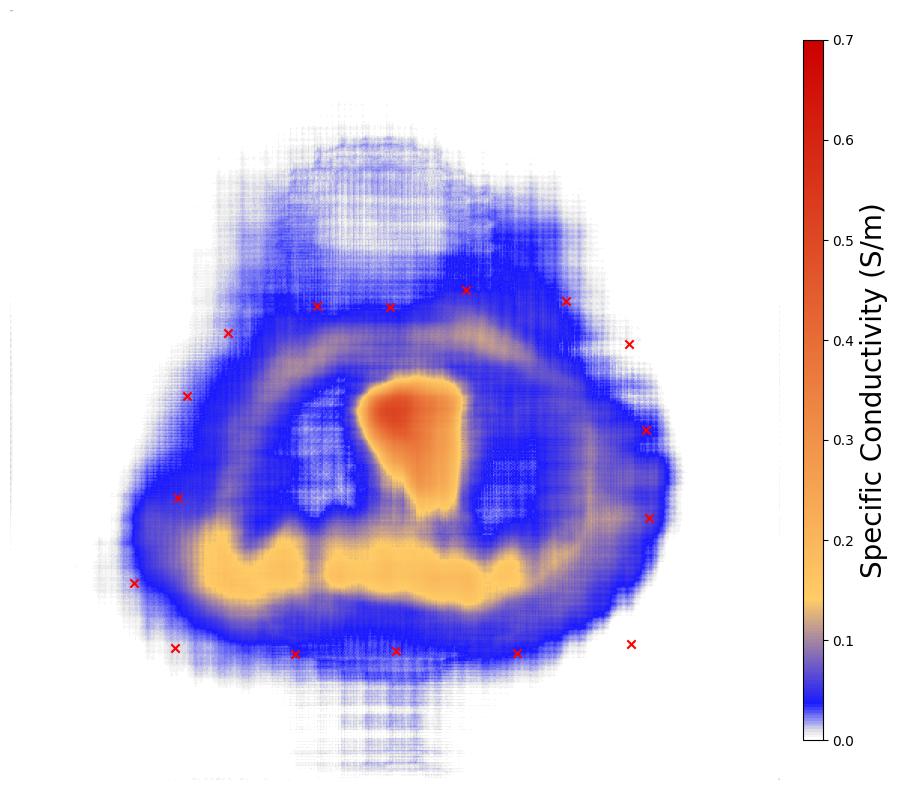

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
ax.imshow(pred, vmin=0.0, vmax=0.7, cmap=cmap)
ax.scatter((real_electrodes[0,:,0]+1)*256, (real_electrodes[0,:,1]+1)*256, marker='x', c='r')
ax.axis('off')
# Add colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
cbar = fig.colorbar(sm, cax=cbar_ax)        
cbar.set_label('Specific Conductivity (S/m)', fontsize=20)
plt.show()

In [103]:
tomogram = read_egt('/home/nibdombe/deep_eit/data/raw/case_11/tomograms_kf/level_1_20.egt')

/scratch/tmp/nibdombe/ipykernel_986/328685249.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(1/tomogram, cmap=cmap, vmin=0., vmax=2)


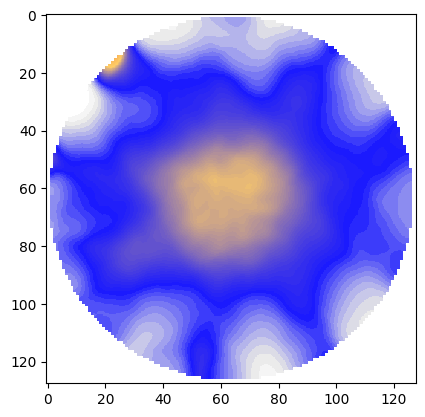

In [112]:
plt.imshow(1/tomogram, cmap=cmap, vmin=0., vmax=2)

In [97]:
gt = read_mat('/home/nibdombe/deep_eit/data/raw/case_11/targets/level_1_20.mat', targets=True)

(-0.5, 250.5, 300.5, -0.5)

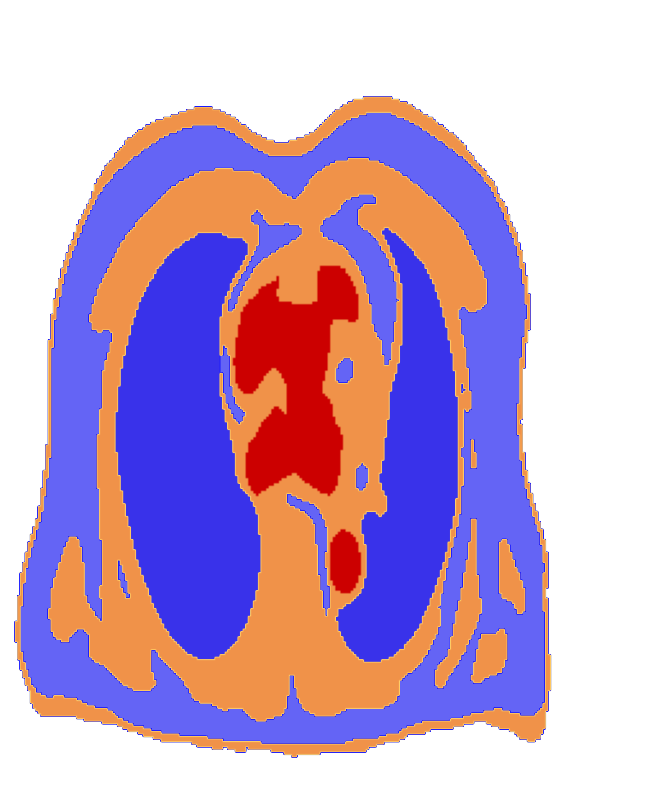

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(gt.T, cmap=cmap, vmin=0., vmax=0.7)
ax.axis('off')